# Detection of grain boundary cations

First, import classes and objects you need later.

In [1]:
import math
# import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import Image

from ovito.io import *
from ovito.plugins.ParticlesPython import VoronoiAnalysisModifier
from ovito.plugins.PyScript import Viewport
from ovito.plugins.TachyonPython import TachyonRenderer
from ovito.plugins.StdModPython import SelectTypeModifier, DeleteSelectedModifier, ColorCodingModifier


C:\Users\alebon\AppData\Local\Temp/ipykernel_27912/1753389544.py:8: UserWarning: Did you accidentally install the OVITO package from the PyPI repository in an Anaconda/Miniconda Python interpreter using the 'pip' command? Note that this will likely lead to conflicts with existing libraries in the Anaconda environment and loading of the OVITO module may subsequently fail with an error related to the Qt framework. In such a case, please uninstall the OVITO pip package first by running 'pip uninstall -y ovito PySide2' and then install the OVITO for Anaconda package using the correct command: 

    conda install --strict-channel-priority -c https://conda.ovito.org -c conda-forge ovito

Visit https://www.ovito.org/python-downloads/ for further installation instructions.
  from ovito.io import *


Read the md LAMMPS data from the data file. It might be necessary to define the Particle Types in the header of the file.

In [2]:
pipeline = import_file("LSF_supercell_md3.lmp")


Add modifiers to the ovito pipeline. Assign particle types, remove anions, calculate Voronoi indices.

In [3]:
def assign_particle_types(frame, data):
    atom_types = data.particles_.particle_types_
    # atom_types.type_by_id_(1).radius = 1.35   # Assing r to atom 1. Needed for polydisperse Voronio tess.


pipeline.modifiers.append(assign_particle_types)

# Select oxygen ions and delete them
pipeline.modifiers.append(SelectTypeModifier(
    operate_on="particles",
    property="Particle Type",
    types={"O"}
))


pipeline.modifiers.append(DeleteSelectedModifier())

# Set up the Voronoi analysis modifier.
voro = VoronoiAnalysisModifier(
    compute_indices=True,
    use_radii=False,
    edge_threshold=0.0
)
pipeline.modifiers.append(voro)

Compute the results in ovito.

In [4]:
data = pipeline.compute()

Plot a histogram for the Max face order.

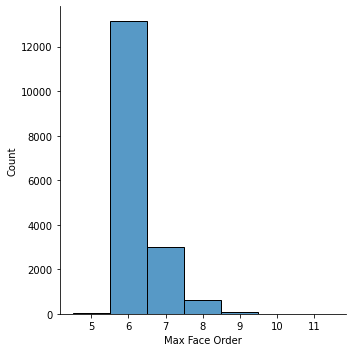

In [5]:
df = pd.DataFrame(list(zip(data.particles['Particle Identifier'], data.particles['Max Face Order'], )),
                  columns=['Particle Identifier', 'Max Face Order'])

hist_plot = sns.displot(df, x="Max Face Order", discrete=True)
fig = hist_plot.fig
fig.savefig("hist.pdf")

Export cations into dump file.

In [6]:
export_file(pipeline, "cations.dump", "lammps/dump",
            columns=["Particle Identifier", "Position.X", "Position.Y", "Position.Z", "Particle Type",
                     "Max Face Order"])

Export two lists, one for GB cation IDs and one for bulk cation IDs.

In [7]:
df_gb = df[df['Max Face Order'] != 6]
df_gb.to_csv('IDs_gb.csv')

df_gb = df[df['Max Face Order'] == 6]
df_gb.to_csv('IDs_bulk.csv')

Render Image.

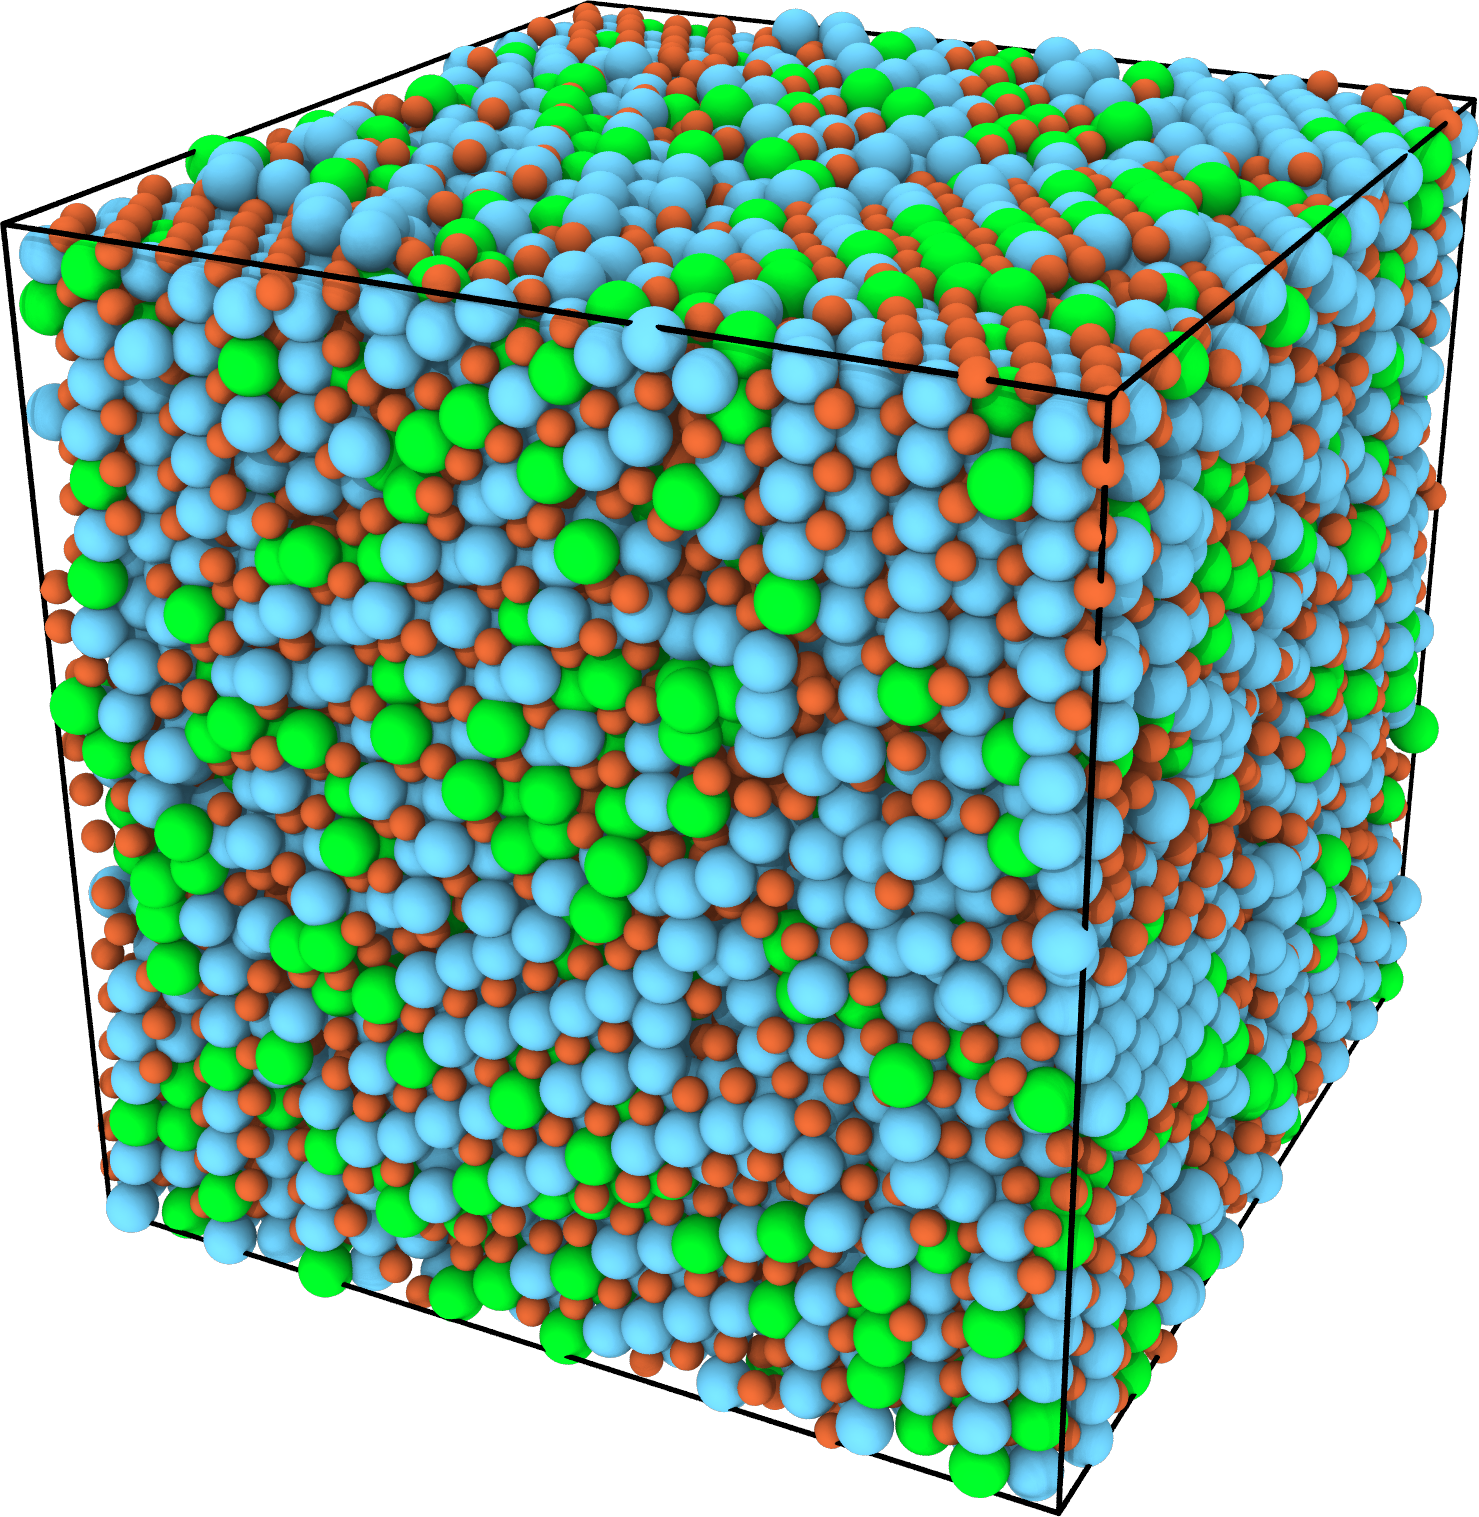

In [14]:
pipeline.add_to_scene()
vp = Viewport(type = Viewport.Type.Ortho)
vp.type = Viewport.Type.Perspective
# vp.camera_pos = (-100, -150, 150)
# vp.fov = math.radians(10.0)
vp.camera_dir = (-1, 2, -1)
vp.zoom_all(size=(640, 480))
res = 4

tachyon = TachyonRenderer(shadows=False, direct_light_intensity=1.1)
image = vp.render_image(size=(res*640, res*480),
                # filename="figure.png",
                background=(1, 1, 1),
                alpha=True,
                renderer=tachyon,
                crop=True)
image.save("figure.png")

Image(filename='figure.png')

# !jupyter nbconvert --to script analyse_cations.ipynb